# Analyse glove wearing of people handling bats

Uses logistic regression to model the probability that someone was using gloves with date as the independent variable

In [1]:
R.Version()$version.string

[1] "R version 3.6.1 (2019-07-05)"

In [2]:
# To read the CSV file of input data
#install.packages("readr") #uncomment if not already installed
library(readr) 


In [3]:
# For plotting the results
#install.packages("ggplot2") #uncomment if not already installed
library(ggplot2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [4]:
# To use a fancy theme in plotting with ggplot
#install.packages("ggthemes") #uncomment if not already installed
library(ggthemes)

Warning message:
"package 'ggthemes' was built under R version 3.6.3"

In [5]:
# To filter and reformat data
#install.packages("dplyr") #uncomment if not already installed
library(dplyr)




Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [6]:
# Widen the data
#install.packages("reshape2") #uncomment if not already installed
library(reshape2)


In [7]:
# To access the iNaturalist API
#install.packages("rinat") #uncomment if not already installed
library(rinat)


Warning message:
"package 'rinat' was built under R version 3.6.3"

In [8]:
# To parse the iNaturalist URL
#install.packages("httr") #uncomment if not already installed
library(httr)

In [9]:
#install.packages("Hmisc") #uncomment if not already installed
library(Hmisc)

Warning message:
"package 'Hmisc' was built under R version 3.6.3"Loading required package: lattice
Loading required package: survival
Warning message:
"package 'survival' was built under R version 3.6.3"Loading required package: Formula
Warning message:
"package 'Formula' was built under R version 3.6.3"
Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units



## Read in the input as a CSV file

In [11]:
handsglovesbats <- read.csv("handsglovesbats.csv")

In [12]:
describe(handsglovesbats)

handsglovesbats 

 3  Variables      1000  Observations
--------------------------------------------------------------------------------
gloveOrHand 
       n  missing distinct 
    1000        0        2 
                      
Value      glove  hand
Frequency    416   584
Proportion 0.416 0.584
--------------------------------------------------------------------------------
observation 
       n  missing distinct 
    1000        0     1000 

lowest : https://www.inaturalist.org/observations/100665   https://www.inaturalist.org/observations/10468158 https://www.inaturalist.org/observations/10623008 https://www.inaturalist.org/observations/10868671 https://www.inaturalist.org/observations/112578  
highest: https://www.inaturalist.org/observations/9529350  https://www.inaturalist.org/observations/9544300  https://www.inaturalist.org/observations/9674556  https://www.naturalista.mx/observations/5373726   https://www.naturalista.mx/observations/5947373  
---------------------------------

In [13]:
## This section converts the words 'gloves' and 'hands' to a binary 1 and 0
handsglovesbats$gloveOrHand <- as.factor(handsglovesbats$gloveOrHand )
handsglovesbats$gloveOrHand <- as.numeric(handsglovesbats$gloveOrHand)
handsglovesbats$gloveOrHand <- handsglovesbats$gloveOrHand -2
handsglovesbats$gloveOrHand <- handsglovesbats$gloveOrHand *-1

## Loop over the input collecting additional data from the iNaturalist API

In [15]:


if(file.exists("dataExtractedFromINAT.csv")){
    print("The data has already been extracted")
    handsglovesbats <- read.csv("dataExtractedFromINAT.csv")
} else {
    for (row in 1:nrow(handsglovesbats)) {
  
        path <- parse_url(handsglovesbats[row,"observation"])$path

        iNaturalistID <- strsplit(path, "/")[[1]][2]

        handsglovesbats[row, "iNaturalistID"]   <- iNaturalistID

        #########################################################################
        # BEWARE THIS CALLS THE iNATURALIST API AND SO SHOULD BE USE CAUTIOUSLY #
        #########################################################################
        observation <- get_inat_obs_id(iNaturalistID)
        
        Sys.sleep(1) # Slow it down so that the API is not overloaded
        
        # Don't collect data for observations that are not licensed
        if(!is.null(observation$license)){
            print(observation$latitude)
            handsglovesbats[row, "observed_on"] <- observation$observed_on
            if(is.null(observation$latitude)){
                handsglovesbats[row, "latitude"] <- 999
                handsglovesbats[row, "longitude"] <- 999
            } else {
                handsglovesbats[row, "latitude"] <- observation$latitude
                handsglovesbats[row, "longitude"] <- observation$longitude
            }

            if(is.null(observation$positional_accuracy)){
                handsglovesbats[row, "positional_accuracy"] <- 0
            } else {
                handsglovesbats[row, "positional_accuracy"] <- observation$positional_accuracy
            }
            handsglovesbats[row, "quality_grade"] <- observation$quality_grade
            handsglovesbats[row, "license"] <- observation$license
            handsglovesbats[row, "captive"] <- observation$captive
            #if no consensus identification has been made the community_taxon_id will be NULL
            if(is.null(observation$community_taxon_id)){ 
                handsglovesbats[row, "taxon_id"] <- observation$taxon_id
            } else {
                handsglovesbats[row, "taxon_id"] <- observation$community_taxon_id
            }
            handsglovesbats[row, "recorded_by"] <- observation$user$login
        }
    }
}

[1] "The data has already been extracted"


## Output the retrived data to a CSV file for storage

In [17]:
if(!file.exists("dataExtractedFromINAT.csv")){
    write.csv(handsglovesbats,"dataExtractedFromINAT.csv")
    }

## Remove the rows where the data are not licenced

In [18]:
handsglovesbats <- handsglovesbats[complete.cases(handsglovesbats[5:5]),]

## Convert the data in text to a real date type

In [19]:
handsglovesbats$observed_on <- as.Date(handsglovesbats$observed_on)

In [20]:
#handsglovesbats$gloveOrHand <- ordered(handsglovesbats$gloveOrHand, levels = c("hand", "glove"))

#levels(handsglovesbats$gloveOrHand) <- c(0,1)

## Create the model

In [21]:
describe(handsglovesbats)

handsglovesbats 

 13  Variables      761  Observations
--------------------------------------------------------------------------------
gloveOrHand 
       n  missing distinct     Info      Sum     Mean      Gmd 
     761        0        2    0.712      295   0.3876   0.4754 

--------------------------------------------------------------------------------
observation 
       n  missing distinct 
     761        0      761 

lowest : https://www.inaturalist.org/observations/100665   https://www.inaturalist.org/observations/10623008 https://www.inaturalist.org/observations/10868671 https://www.inaturalist.org/observations/112578   https://www.inaturalist.org/observations/11388729
highest: https://www.inaturalist.org/observations/93980    https://www.inaturalist.org/observations/9529350  https://www.inaturalist.org/observations/9544300  https://www.inaturalist.org/observations/9674556  https://www.naturalista.mx/observations/5373726  
----------------------------------------------------

In [22]:
modelLG <- glm(gloveOrHand ~ observed_on,family=binomial(link='logit'),data=handsglovesbats)

summary(modelLG)


Call:
glm(formula = gloveOrHand ~ observed_on, family = binomial(link = "logit"), 
    data = handsglovesbats)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1232  -1.0326  -0.8282   1.2456   2.2443  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.818e+00  7.330e-01  -5.208 1.91e-07 ***
observed_on  1.978e-04  4.257e-05   4.647 3.37e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1016.22  on 760  degrees of freedom
Residual deviance:  991.29  on 759  degrees of freedom
AIC: 995.29

Number of Fisher Scoring iterations: 4


In [23]:
summary(handsglovesbats)

  gloveOrHand                                                observation 
 Min.   :0.0000   https://www.inaturalist.org/observations/100665  :  1  
 1st Qu.:0.0000   https://www.inaturalist.org/observations/10623008:  1  
 Median :0.0000   https://www.inaturalist.org/observations/10868671:  1  
 Mean   :0.3876   https://www.inaturalist.org/observations/112578  :  1  
 3rd Qu.:1.0000   https://www.inaturalist.org/observations/11388729:  1  
 Max.   :1.0000   https://www.inaturalist.org/observations/117460  :  1  
                  (Other)                                          :755  
      year      iNaturalistID       observed_on           latitude        
 Min.   :1984   Length:761         Min.   :1984-07-16   Length:761        
 1st Qu.:2013   Class :character   1st Qu.:2013-10-20   Class :character  
 Median :2017   Mode  :character   Median :2017-09-08   Mode  :character  
 Mean   :2016                      Mean   :2016-03-05                     
 3rd Qu.:2020                    

In [24]:
# Odds Ratio
oddrat <- exp(coef(modelLG))
oddrat

anova(modelLG, test="Chisq")

(Intercept) observed_on 
  0.0219729   1.0001978

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,760,1016.2155,NA
observed_on,1,24.92494,759,991.2906,5.960628e-07


## Display the results in a graph

Warning message:
"Ignoring unknown parameters: height, width"

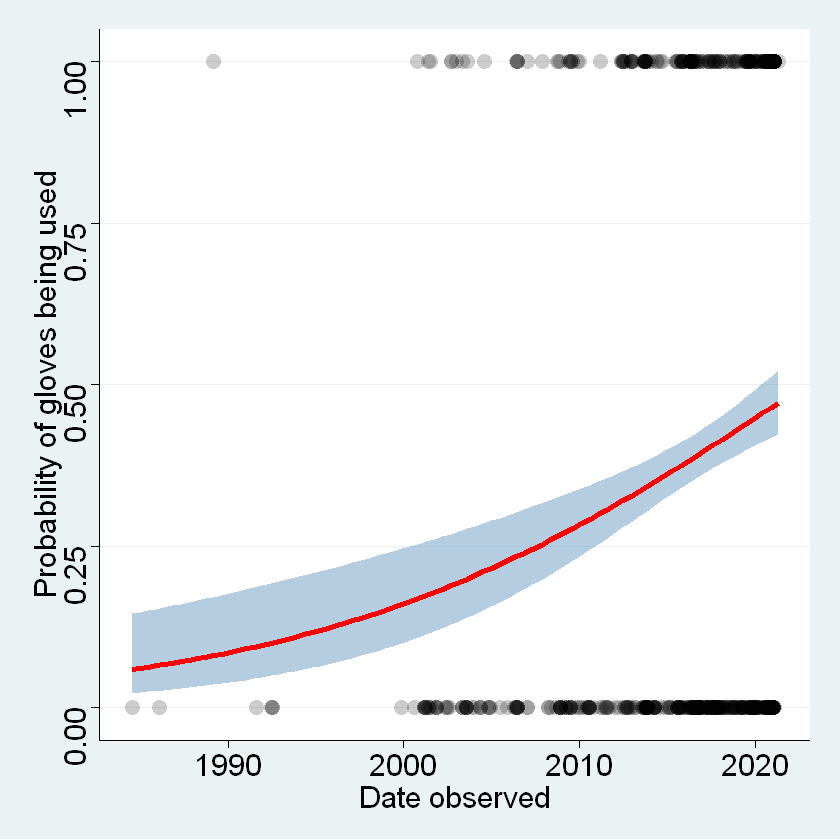

In [25]:
ggplot(handsglovesbats, aes(x=observed_on, y=gloveOrHand)) + 
  geom_point(height = 0.03, width=0.3, shape=16, alpha = 0.2, size=4) +
  #geom_jitter(height = 0.03, width=0.3, shape=1, alpha = 0.4) +
  #scale_x_continuous(breaks = seq(2008, 2021, by = 3)) +
  stat_smooth(formula = y ~ x, method="glm", method.args=list(family="binomial"), se=TRUE, fill = "steelblue", inherit.aes = TRUE, size = 1.5, linetype = 1, colour = "red") +
  labs(y = "Probability of gloves being used", x = "Date observed") + theme_stata(base_size = 20, base_family = "sans", scheme = "s2color")

## Output the plot as high quality files

In [26]:
ggsave(
  "gloveprobability.tiff",
  plot = last_plot(),
  device = "tiff",
  scale = 1,
  width = 242.7,
  height = 150,
  units = c("mm"),
  dpi = 300
)

ggsave(
  "gloveprobability.jpg",
  plot = last_plot(),
  device = "jpg",
  scale = 1,
  width = 242.7,
  height = 150,
  units = c("mm"),
  dpi = 300
)

## See where the observations come from

In [27]:
handsglovesbats$longitude[handsglovesbats$longitude == 999] <- NA
handsglovesbats$latitude[handsglovesbats$latitude == 999] <- NA

handsglovesbats$longitude <- as.numeric(handsglovesbats$longitude)
handsglovesbats$latitude <- as.numeric(handsglovesbats$latitude)

handsglovesbats$gloveOrHand <- as.factor(handsglovesbats$gloveOrHand )

Warning message:
"Removed 2 rows containing missing values (geom_point)."

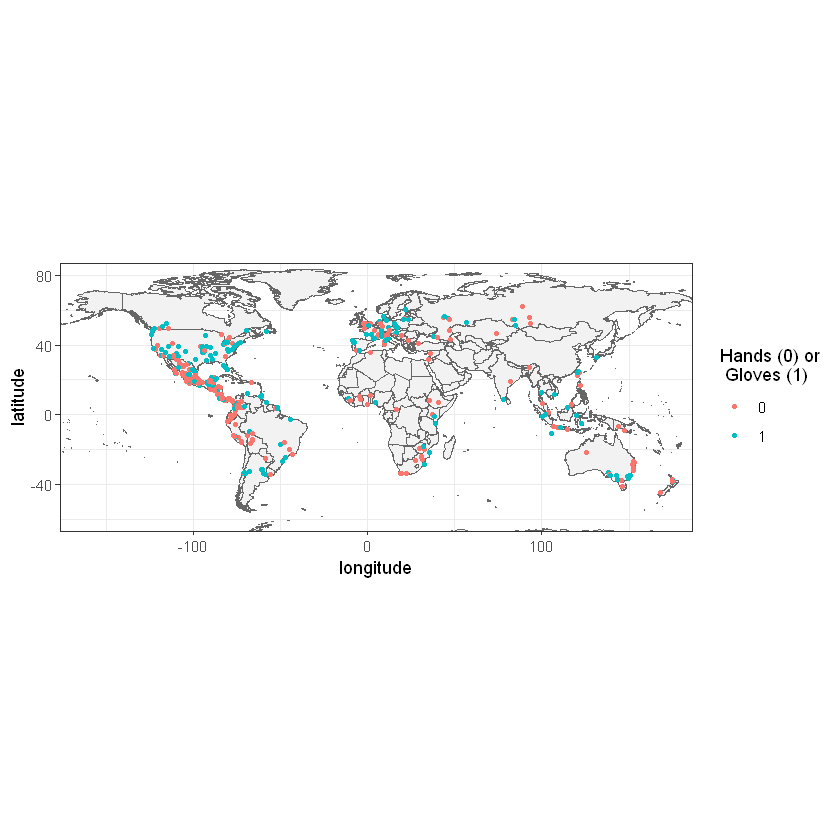

In [32]:
## A more elaborate map of Colibri sp.
ggplot(data = handsglovesbats, aes(x = longitude,
                             y = latitude,
                             colour = gloveOrHand)) +
      geom_polygon(data = map_data("world"),
                       aes(x = long, y = lat, group = group),
                       fill = "grey95",
                       color = "gray40",
                       size = 0.1) +
      geom_point(size = 1, alpha = 1) +
      #coord_fixed(xlim = range(handsglovesbats$longitude, na.rm = TRUE),
      #            ylim = range(handsglovesbats$latitude, na.rm = TRUE)) +
        coord_fixed(ylim = c(-60,80),
                  xlim = c(-160,170)) +
        labs(color = "Hands (0) or\n Gloves (1)") +
        theme_bw()

In [33]:
ggsave(
  "glovemap.tiff",
  plot = last_plot(),
  device = "tiff",
  scale = 1,
  width = 242.7,
  height = 150,
  units = c("mm"),
  dpi = 300
)

ggsave(
  "glovemap.jpg",
  plot = last_plot(),
  device = "jpg",
  scale = 1,
  width = 242.7,
  height = 150,
  units = c("mm"),
  dpi = 300
)

Warning message:
"Removed 2 rows containing missing values (geom_point)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

handsglovesbats

In [44]:
handsglovesbats

,gloveOrHand,observation,year,iNaturalistID,observed_on,latitude,longitude,positional_accuracy,quality_grade,license,captive,taxon_id,recorded_by
1,1,https://www.inaturalist.org/observations/100665,2012,100665,2012-07-10,41.011000,-81.684333,0,research,CC-BY,FALSE,40509,jwhittle
3,0,https://www.inaturalist.org/observations/10623008,2018,10623008,2018-03-16,42.158061,9.398053,0,research,CC-BY,FALSE,40695,jujurenoult
4,0,https://www.inaturalist.org/observations/10868671,2018,10868671,2018-02-17,19.508945,-103.710766,1030,needs_id,CC-BY-NC,FALSE,40992,zamboiro
5,0,https://www.inaturalist.org/observations/112578,2012,112578,2012-04-13,4.746486,-76.293932,2118,needs_id,CC-BY,FALSE,41039,damonsalveo
6,1,https://www.inaturalist.org/observations/11388729,2018,11388729,2018-04-18,41.606241,-73.051556,5888,research,CC-BY-NC,FALSE,40523,lindabowen
7,0,https://www.inaturalist.org/observations/117460,2012,117460,2012-08-28,41.298249,-81.456460,0,research,CC-BY,FALSE,183166,mperdicas
10,0,https://www.inaturalist.org/observations/120500,2010,120500,2010-10-18,7.743067,-72.558583,0,research,CC-BY-NC,FALSE,74518,arleyo
12,0,https://www.inaturalist.org/observations/121810,2012,121810,2012-09-11,41.274409,-81.497865,0,research,CC-BY,FALSE,40349,jwhittle
13,0,https://www.inaturalist.org/observations/122214,2012,122214,2012-09-13,42.582826,-80.398481,100,research,CC-BY-NC,FALSE,40629,pcatling
14,1,https://www.inaturalist.org/observations/123931,2007,123931,2007-01-02,10.379174,-84.110749,0,research,CC-BY-NC,FALSE,41221,kucycads


## How many people used gloves?


In [58]:
handsglovesbats %>% count(recorded_by, gloveOrHand ) %>% filter(gloveOrHand == 1) %>% count(recorded_by) %>% count(n)

n,nn
1,165


## How many people didn't use gloves?

In [57]:
handsglovesbats %>% count(recorded_by, gloveOrHand ) %>% filter(gloveOrHand == 0) %>% count(recorded_by) %>% count(n)

n,nn
1,214


## How many people did both?

In [61]:
handsglovesbats %>% count(recorded_by, gloveOrHand ) %>%  count(recorded_by) %>% count(n) %>% filter(n == 2)

n,nn
2,38


In [104]:
users <- handsglovesbats %>% count(recorded_by, gloveOrHand ) 

## Who did both?

In [101]:
both <- handsglovesbats %>% count(recorded_by, gloveOrHand ) %>% count(recorded_by) %>% filter(n == 2)

In [102]:
both %>% arrange(desc(n)) 

recorded_by,n
alexanderyuz,2
axlramone,2
bio_jpacheco,2
birdchuvashia,2
carlosfunes37,2
carloshrussi,2
charliev,2
christoph_moning,2
courtharding,2
edward137,2


In [112]:
total <- merge(users,both,by="recorded_by") 

In [113]:
total %>% mutate(n.x / n.y)

recorded_by,gloveOrHand,n.x,n.y,n.x/n.y
alexanderyuz,1,10,2,5.0
alexanderyuz,0,2,2,1.0
axlramone,1,2,2,1.0
axlramone,0,1,2,0.5
bio_jpacheco,1,4,2,2.0
bio_jpacheco,0,5,2,2.5
birdchuvashia,0,1,2,0.5
birdchuvashia,1,1,2,0.5
carlosfunes37,0,5,2,2.5
carlosfunes37,1,11,2,5.5


In [114]:
write.csv(total,"users.csv")